# LLM Agents for Clinical Trial Management - Patient Evaluation Workflow

In this notebook, we demonstrate how an agent-based Large Language Model (LLM) can be applied to automate the evaluation of patients for potential clinical trials. 
By utilizing documents related to patient medical histories, clinical policies, and trial inclusion criteria, this notebook illustrates the end-to-end process of assessing patient eligibility.

**Objective**: Showcase the implementation of clinical trial data management, compliance verification, and automated matching of patients to suitable trials using advanced LLM techniques.

### Key Processes Covered in this Notebook:
1. **Data Collection and Preprocessing**: Importing and preparing patient data.
2. **Patient Profile Analysis**: Using LLMs to analyze patient data and extract relevant information.
3. **Eligibility Verification**: Assessing patient data against clinical trial policies to determine eligibility.
4. **Trial Matching**: Utilizing agentic workflows to identify suitable trials for patients.
5. **Hallucination Prevention**: Using a hallucination grader to ensure model outputs are contextually accurate.

### Note
This notebook uses simplified demo data for the purpose of illustrating the capabilities of an LLM-driven agentic pipeline. For production-level implementation, clinical expertise, comprehensive datasets, and advanced tools (e.g., advanced Retrieval-Augmented Generation (RAG)) are required.

Let's get started by setting up the environment and importing the necessary libraries.

## Visual Representation of the Pipeline:
<image src="../images/diagram.png" alt="Pipeline Diagram" width="800"/>

# Loading libraries

In [1]:
%load_ext autoreload
%autoreload 2
import getpass
import os
import pandas as pd
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_core.documents import Document
import chromadb

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

# Loading the requied environment variables
_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Clinical Trial Management"

USER_AGENT environment variable not set, consider setting it to identify your requests.


# Parameters

In [21]:
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

free_model = True

policy_vstore_created = False
trials_vstore_created = False
trials_db_downloaded = False
trials_path = "../data/trials_data.csv" 

DEBUG = False

chromadb_path = "../chroma_db"
policy_collection = "policy-chroma"
trial_collection = "trial-chroma"

# OpenAI models
modelID = "gpt-3.5-turbo"
modelID_agent = "gpt-4o"
# modelID_agent = "gpt-3.5-turbo"

# Groq models
# modelID_groq = "gemma2-9b-it"
modelID_groq = "llama-3.1-8b-instant"
# modelID_groq = "mistral-saba-24b"
# modelID_groq_agent = "llama-3.3-70b-versatile"
modelID_groq_agent = modelID_groq


n_retrieved_policies = 5 # Number of most relevant policies to retrieve per patient
n_retrieved_trials = 6

if free_model:    
    model = ChatGroq(model=modelID_groq, temperature=0)
    model_agent = ChatGroq(model=modelID_groq_agent, temperature=0)
    print(f"Using Groq model: {modelID_groq}")
else:
    model = ChatOpenAI(temperature = 0.0, model=modelID)
    model_agent = ChatOpenAI(temperature=0, model=modelID_agent)
    print(f"Using OpenAI model: {modelID}")



Using Groq model: llama-3.1-8b-instant


In [3]:
import warnings
warnings.filterwarnings("ignore")

import pprint
# A function for printing nicely
def nprint(text, indent=2):
    pp = pprint.PrettyPrinter(indent=indent)
    pp.pprint(text)

# Creating the demo datasets

## Patients database

We create a sample dataset of patients with their medical history, previous trials, and other relevant information.   
We use random names, diseases, and past or ongoing trials.  
This is a demo dataset limited information. However, for real cases, a more complit medical history of patients will be used.

In [4]:
# import os
import sqlite3
import sys
sys.path.append('/Users/bobhosseini/Portfolio/llm_pharma')
from backend.helper_functions import create_demo_patient_database
database_file = "sql_server/patients.db"
df = create_demo_patient_database(database_file)
df.head()

Demo patient database created at: /Users/bobhosseini/Portfolio/llm_pharma/sql_server/patients.db
CSV export created at: /Users/bobhosseini/Portfolio/llm_pharma/data/patients.csv
Total patients created: 100


,patient_id,name,age,medical_history,previous_trials,trial_status,trial_completion_date
0,1,Oliver Thomas,52,depressive disorder,NCT01087465,Completed,2023-09-23
1,2,James Anderson,72,mesothelioma,,,
2,3,Jane Smith,21,myeloid leukemia,,,
3,4,Alice Doe,69,solid tumors,,,
4,5,Michael Garcia,44,mesothelioma,NCT03303352,Completed,2023-11-16


Creating a local SQLite database for patients

In [5]:
conn = sqlite3.connect('../' + database_file)
cursor = conn.cursor()

query = 'SELECT * FROM patients'

# Execute the query and fetch all results
cursor.execute(query)
rows = cursor.fetchall()

# Optionally, you can get the column names
column_names = [description[0] for description in cursor.description]

# Convert the results to a Pandas DataFrame for better readability
df = pd.DataFrame(rows, columns=column_names)
print(len(df))

# Display the DataFrame
conn.close()

db = database_file
df.head(10)

100


,patient_id,name,age,medical_history,previous_trials,trial_status,trial_completion_date
0,1,Oliver Thomas,52,depressive disorder,NCT01087465,Completed,2023-09-23
1,2,James Anderson,72,mesothelioma,,,
2,3,Jane Smith,21,myeloid leukemia,,,
3,4,Alice Doe,69,solid tumors,,,
4,5,Michael Garcia,44,mesothelioma,NCT03303352,Completed,2023-11-16
5,6,Emma Johnson,71,prostate cancer,NCT05771631,Withdrawn,2024-01-29
6,7,Alice Garcia,76,rectal cancer,NCT04984428,Withdrawn,2023-08-02
7,8,Daniel Doe,50,myeloma,NCT03127828,Withdrawn,2023-11-20
8,9,Alice Johnson,44,prostate cancer,,,
9,10,Emma Doe,62,colorectal cancer,,,


## Clinical Trials database

We download a sample clinical trials database from a [publicly available source]('https://raw.githubusercontent.com/futianfan/clinical-trial-outcome-prediction/main/data/raw_data.csv').   
Details are provided in the [helper function](../../src/helper_functions.py)

In [6]:
import sys
module_dir = os.path.abspath('../backend')  # Gets the absolute path to the src directory
sys.path.append(module_dir)
from helper_functions import dataset_create_trials

overwrite = False
trials_db_downloaded = True
if trials_db_downloaded and not overwrite:
    print(f'Trials database already downloaded and stored in {trials_path}')
    df_trials = pd.read_csv(trials_path)
    import ast
    df_trials['diseases'] = df_trials['diseases'].apply(ast.literal_eval)
    # df_trials['drugs'] = df_trials['drugs'].apply(ast.literal_eval)
else:
    df_trials, trials_path = dataset_create_trials(status='recruiting')
    trials_db_downloaded = True

# print the ctriteria column value froom 4 random rows of the dataferam. use a for loop
df_samples = df_trials.sample(4).reset_index(drop=True)
for i in range(2):
    print(f'---- Sample {i+1} ----')
    print(df_samples.iloc[i]['criteria'])


Trials database already downloaded and stored in ../data/trials_data.csv
---- Sample 1 ----

        Cohort A: STS

        Inclusion Criteria:

          1. The patient must sign voluntarily the informed consent form before any study test is
             conducted that is not part of routine patient care.

          2. Aged equal or over 18.

          3. Patients must have a diagnostic of Soft Tissue Sarcoma with metastasis limited to
             lung, and not suitable for metastasectomy or surgery resection or not oncologically
             recommended metastasectomy.A centralized diagnostic will be performed, the tumor
             sample must be available and sent prior to inclusion.

          4. Disease distribution allows meeting with normal tissue constraints of radiation
             therapy. Radiation oncologist must confirm this point.

          5. Metastatic spread could be present in two organs at maximum (i.e. lungs and pelvic
             fosa).

          6. Those le

# Creating Vectore Stores

## Vstore for policy database

To create a vector store for the policy database, we will use perform local embedding via NomicEmbeddings.   
Also, to treat each policy separately, we split the policies main document into per policy chunks.   
Note that this is a problem specific strategy, and may not be appropriate for all RAG applications.

In [7]:
import re

# from langchain.text_splitter import RecursiveCharacterTextSplitter
# from langchain_community.document_loaders import WebBaseLoader
# from langchain_community.vectorstores import Chroma
# from langchain_nomic.embeddings import NomicEmbeddings
# from langchain_community.document_loaders import UnstructuredMarkdownLoader
# from langchain_core.documents import Document
# import chromadb

vstore_load = False # change to True to load existing vectorstore
markdown_path = "../source_data/instut_trials_policy.md"

with open(markdown_path, "r") as f:
    policy_text = f.read()


doc_splits = [
    Document(page_content= txt, metadata={"source": markdown_path}) for txt in re.split(r"(?=\n###)", policy_text)
    ]

# the title of markdown is not required in the split
doc_splits = doc_splits[1:]    

print(len(doc_splits))
doc_splits

persistent_client = chromadb.PersistentClient(path = chromadb_path)

if vstore_load == False:
    try:
        vectorstore.delete_collection()
        print('Vectore store deleted')
    except:
        print('No existing vectorstore')

if os.path.exists(chromadb_path) and vstore_load:     
    vectorstore = Chroma(
        client=persistent_client,
        collection_name=policy_collection,
        embedding_function=NomicEmbeddings(model="nomic-embed-text-v1.5",
                                inference_mode='local'),
    )
    print('Vectore store loaded from existing chromadb')
else:
    vectorstore = Chroma.from_documents(
        documents=doc_splits,
        client=persistent_client,
        collection_name=policy_collection,
        # persist_directory=chromadb_path,
        embedding=NomicEmbeddings(model="nomic-embed-text-v1.5",
                                inference_mode='local'),
    )
    print('Vectore store created and stored in persistent chromadb client')

print(vectorstore._collection.count())
doc_splits[0]


12
No existing vectorstore


Embedding texts: 100%|██████████| 12/12 [00:00<00:00, 59.70inputs/s]

Vectore store created and stored in persistent chromadb client
12


Document(metadata={'source': '../source_data/instut_trials_policy.md'}, page_content='\n#### 1. **General Eligibility Criteria**\n   - **Age Restrictions**: Patients must be between 18 and 75 years old.\n   - **Gender**: No restrictions unless specified by the trial protocol.\n   - **Informed Consent**: All patients must provide informed consent prior to participation.\n   - **Residency**: Patients must be residents of the country where the trial is conducted.\n   - **Health Insurance**: Patients must have valid health insurance coverage.\n')

## Vstore for trials

For simplicy, we just work on 3 main categories of cancer, lukemia, and mental health problems.   
This selection gives us a managable set of trials as a demo application.   
However, for a more proper application, categories can be extended with the help of domain specialists.

The vectore store is created using chromadb and as a persistent client.

In [8]:
from helper_functions import create_trial_vectorstore

vectorstore = create_trial_vectorstore(
    trials_csv_path='data/trials_data.csv',
    vectorstore_path=chromadb_path,
    collection_name=trial_collection,
    status_filter="recruiting",
    vstore_delete=True
)
# vectorstore_trials._coll
# from helper_functions import disease_map
# from langchain_core.documents import Document

# vstore_delete = False
# print(f"total trials: {len(df_trials)}")

# trial_docs = []
# for i, row in df_trials.iterrows():
#     disease = disease_map(row['diseases'])
#     if disease == 'other_conditions':
#         continue
#     doc = Document(
#         page_content=row['criteria'],
#         metadata={
#             "nctid": row['nctid'],
#             "status": row['status'],
#             # "why_stop": row['why_stop'],
#             # "label": row['label'],
#             # "phase": row['phase'],
#             "diseases": str(row['diseases']),
#             "disease_category": disease[0],
#             "drugs": row['drugs'],            
#         }
#     )
#     trial_docs.append(doc)
# # trial_docs

# print(trial_docs[0].metadata)

# list_remove = set()
# for i, doc in enumerate(trial_docs):
#     if len(doc.page_content)>10000:
#         # print(f"trial {i} is too long")
#         list_remove.add(i)
#         # print(doc.metadata)
#     if doc.metadata['disease_category'] == 'other_conditions':
#         # print(f"trial {i} is other conditions")
#         list_remove.add(i)
#         # print(doc.metadata)
# # remove list_remove indexes from trial_docs
# trial_docs = [doc for i, doc in enumerate(trial_docs) if i not in list_remove]
# print(f"Number of trials to be added to the vector store: {len(trial_docs)}")

# # print(len(trial_docs[11].page_content))
# # trial_docs.pop(11)

# persistent_client = chromadb.PersistentClient(path = chromadb_path)

# if vstore_delete == True:
#     vectorstore_trials.delete_collection()
#     trials_vstore_created = False
#     vstore_delete = False
#     print("vstore deleted")

# vectorstore_trials = Chroma(
#     client=persistent_client,
#     collection_name=trial_collection,
#     embedding_function=NomicEmbeddings(model="nomic-embed-text-v1.5",
#                             inference_mode='local'),
# )
# if vectorstore_trials._collection.count() == 0:
#     vectorstore_trials = Chroma.from_documents(
#         documents=trial_docs,
#         client=persistent_client,
#         collection_name=trial_collection,
#         # persist_directory=chromadb_path,
#         embedding=NomicEmbeddings(model="nomic-embed-text-v1.5",
#                                 inference_mode='local'),
#     )
#     trials_vstore_created = True
#     print("Vectorstore is created now")
# else:
#     print("Loading the vectorstore from persistent client")

# # collection = persistent_client.get_collection(name=trial_collection)
# print(f"Number of trials in the vector store: {vectorstore_trials._collection.count()}")
# trial_docs[0]


Collection trial-chroma is deleted
/Users/bobhosseini/Portfolio/llm_pharma/data/trials_data.csv
loaded trials: 30
✅ Filtered trials to status 'recruiting': 30 trials
sample trial doc metadata:
 {'nctid': 'NCT00715611', 'status': 'recruiting', 'diseases': "['mesothelioma']", 'disease_category': 'cancer', 'drugs': "['pemetrexed and cisplatin or carboplatin']"}
removing trial 3 because it's for other conditions
removing trial 4 because it's for other conditions
removing trial 9 because it's for other conditions
removing trial 11 because it's too long
removing trial 12 because it's for other conditions
removing trial 14 because it's for other conditions
removing trial 16 because it's for other conditions
removing trial 17 because it's for other conditions
removing trial 18 because it's for other conditions
removing trial 23 because it's for other conditions
removing trial 25 because it's for other conditions
removing trial 27 because it's for other conditions
Number of trial docs to be add

Embedding texts: 100%|██████████| 18/18 [00:02<00:00,  8.47inputs/s]

✅ Trial vector store created with 18 trials


# Tools:
Here we define some tools that the agent needs to use for evaluation of the patient, general policies, and clinic trials.
Below is the list of tools:
- Patient Data Extractor
- Profile Maker
- Policy Retriever
- Policies to Questions
- Policy Evaluator with Python Tools (multiply, date_today, date_difference, date_convert, date_split, number_compare)
- Trials Retriever 
- Trial Grader
- Hallucination Grader
- Profile Rewriter

### Patient Data Extractor
This tool extracts patient data from the sqlite database using the patient_id.

In [9]:
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

from backend.helper_functions import get_patient_data

# def get_patient_data(patient_id: int) -> dict:
#     """Fetch all fields for the patient based on the given patient_id as an integer.

#     Returns:
#         A dictionary containing the patient's medical history.        
#     """    

#     conn = sqlite3.connect(db)
#     cursor = conn.cursor()    
#     query = 'SELECT * FROM patients WHERE patient_id=?'
#     cursor.execute(query, (patient_id,))
#     patient_data = cursor.fetchone()
#     # rows = cursor.fetchall()
#     column_names = [column[0] for column in cursor.description]
#     conn.close()
#     if patient_data is None:
#         return None
#     else:    
#         results = dict(zip(column_names, patient_data))    
#     return results

# Also possible to add a new patient
def add_patient_data(patient_data: dict):    
    """Adds a new patient to the SQLite database."""
    
    name = patient_data['name']
    age = patient_data['age']
    medical_history = patient_data['medical_history']
    previous_trials = patient_data['previous_trials']
    trial_status = patient_data['trial_status']
    last_trial_dates = patient_data['last_trial_dates']

    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    
    # Insert the new patient data into the database
    cursor.execute('''
    INSERT INTO patients (name, age, medical_history, previous_trials, trial_status, last_trial_dates)
    VALUES (?, ?, ?, ?, ?, ?)
    ''', (name, age, medical_history, previous_trials, trial_status, last_trial_dates))
    
    conn.commit()
    conn.close()

In [10]:
sample_patient_id = 1
patient_data = get_patient_data(sample_patient_id)
patient_data

{'patient_id': 1,
 'name': 'Oliver Thomas',
 'age': 52,
 'medical_history': 'depressive disorder',
 'previous_trials': 'NCT01087465',
 'trial_status': 'Completed',
 'trial_completion_date': '2023-09-23'}

### Profile Maker
This tool creates a a text description of the patient data as the parient profile.   
It also suggest possible relevant medical trial categories based on the patient's disease history. 

In [11]:
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate

parser = StrOutputParser()
prompt_profile = PromptTemplate(
    template="""
    You are the Clinical Research Coordinator in the screening phase of a clinical trial. 
    Use the following patient data to write the patient profile for the screening phase.
    The patient profile is a summary of the patient's information in continuous text form.    
    If they had no previous trial participation, exclude trial status and trial completion date.\n
    Do not ignore any available information.\n 
    Also suggest medical trials that can be related to patient's disease history.\n    
    Write the patient profile in 3 to 4 short sentences.\n\n
    {patient_data}""",
    input_variables=["patient_data"],
)
# In a separate section of the profile, also suggest medical trial categories related to patient's disease history.\n    
# model = ChatOpenAI(temperature = 0.0, model=modelID)

chain_profile = prompt_profile | model | parser
# to preserve the patient's private information

In [12]:
# to preserve the patient's private information
if patient_data.get('name'):
    del patient_data['patient_id']
    del patient_data['name']

patient_profile = chain_profile.invoke({'patient_data': patient_data})
nprint(patient_profile) # patient_profile

('The patient is a 52-year-old individual with a medical history of depressive '
 'disorder. They previously participated in the clinical trial identified by '
 'NCT01087465, which they completed on September 23, 2023. Given their medical '
 'history, relevant medical trials could include studies focused on the '
 'treatment and management of depressive disorders, such as those '
 'investigating new antidepressant medications, cognitive-behavioral '
 'therapies, or other innovative approaches to mental health treatment.')


### Policy Retriever
A retriever tool that retrieves relevant policies from policy documents based on the patient profile.

In [13]:
retriever_policy = vectorstore.as_retriever(search_kwargs={"k": n_retrieved_policies})

# sample policy retrieval
docs_retrieved = retriever_policy.get_relevant_documents(patient_profile)
print(len(docs_retrieved))
doc_txt = docs_retrieved[0].page_content
nprint(doc_txt)
docs_retrieved

Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 34.49inputs/s]

5
('\n'
 '        Inclusion Criteria:\r\n'
 '\r\n'
 '          1. Able to understand and comply with the study procedures, '
 'understand the risks involved\r\n'
 '             in the study, and provide written informed consent before the '
 'first study-specific\r\n'
 '             procedure; specifically able to comply with the PK assessment '
 'schedule during the\r\n'
 '             first 2 treatment cycles.\r\n'
 '\r\n'
 '          2. Men or women ≥18 years who are candidates to receive IV '
 'decitabine according to FDA or\r\n'
 '             European Medicines Agency (EMA) approved indications:\r\n'
 '\r\n'
 '               1. In North America: Participants with MDS previously treated '
 'or untreated with de\r\n'
 '                  novo or secondary MDS, including all '
 'French-American-British subtypes (refractory\r\n'
 '                  anemia, refractory anemia with ringed sideroblasts, '
 'refractory anemia with excess\r\n'
 '                  blasts, refractory anemia w

[Document(metadata={'nctid': 'NCT03306264', 'status': 'recruiting', 'diseases': "['myelodysplastic syndromes', 'chronic myelomonocytic leukemia', 'acute myeloid leukemia']", 'disease_category': 'leukemia', 'drugs': "['astx727', 'dacogen']"}, page_content="\n        Inclusion Criteria:\r\n\r\n          1. Able to understand and comply with the study procedures, understand the risks involved\r\n             in the study, and provide written informed consent before the first study-specific\r\n             procedure; specifically able to comply with the PK assessment schedule during the\r\n             first 2 treatment cycles.\r\n\r\n          2. Men or women ≥18 years who are candidates to receive IV decitabine according to FDA or\r\n             European Medicines Agency (EMA) approved indications:\r\n\r\n               1. In North America: Participants with MDS previously treated or untreated with de\r\n                  novo or secondary MDS, including all French-American-British subt

### Policies to Questions
Each main policy document also consists of a list of sub-policies related to the same category. For example, a policy may contain eligible and non-eligible sub-policies for a give patient. This is a challenging condition for an llm to determine the patient's eligibility in a single shot attempt.   
To assist the llm and prevent possible mistakes, we convert each subpolicy to a direct yes/no question with a yes answer indicating the patient is not eligible.   
We define an llm chain for that purpose.

In [14]:
# Policies --> questions
from langchain_core.pydantic_v1 import BaseModel, Field

prompt_rps = PromptTemplate(
    template=""" You are a Principal Investigator (PI) for clinical trials. 
        The following document contains a policy document about participation in clinial trials:
        \n\n{policy}\n\b

        Your task is to rephrase each single policy from the document above into a single yes/no question. 
        Form each question so that a yes answer indicates the patient's ineligibility.
        Do not create more questions than given number of policies.

        Example: Patients who have had accidents in the past 10 months are not eligible
        rephrased: Did patient have an accident in the past 10 months?

        Example: Patients with active tuberculosis, hepatitis B or C, or HIV are excluded unless the trial is specifically designed for these conditions.
        rephrased: Did patient have active tuberculosis, hepatitis B or C, or HIV?
        """,
    input_variables=["policy"],
)

class policy_relevance(BaseModel):
    "policy relevance score"

    relevant: str = Field(description="is policy relevant? 'yes' or 'no'.")
    reason: str

parser = StrOutputParser()

policy_rps_chain = prompt_rps | model | parser


In [15]:

policy = docs_retrieved[0].page_content
policy_qs = policy_rps_chain.invoke({"policy": policy})
nprint(policy_qs)

('1. Is the patient unable to understand and comply with the study procedures, '
 'understand the risks involved in the study, and provide written informed '
 'consent before the first study-specific procedure, or unable to comply with '
 'the PK assessment schedule during the first 2 treatment cycles?\n'
 '2. Is the patient younger than 18 years or not a candidate to receive IV '
 'decitabine according to FDA or EMA approved indications?\n'
 '3. Is the patient in North America and not a participant with MDS previously '
 'treated or untreated with de novo or secondary MDS, including all '
 'French-American-British subtypes (refractory anemia, refractory anemia with '
 'ringed sideroblasts, refractory anemia with excess blasts, refractory anemia '
 'with excess blasts in transformation, and chronic myelomonocytic leukemia '
 '[CMML]), and subjects with MDS International Prognostic Scoring System '
 '(IPSS) int-1, -2, or high-risk MDS?\n'
 '4. Is the patient in Europe and not a particip

### Policy Evaluator with Python Tools

The policy evaluator uses Python tools to evaluate the patient's eligibility.
More often the patient's profiles or the policy documents contain date or numeric information. However, llms are not able to process these types of information properly. Therefore, we use Python tools for the model to perform numerical or date calculations and convertions.

Note: You can also try the python REPL tool to give LLM more flexibility and freedon to do all kinds of calculations. However, this tool needs fine-tuned guardrails and also clear instructions on how to use it. Otherwise llm may use it even for non-numerical simulations.

In [16]:
from langchain_core.tools import StructuredTool
from datetime import date, datetime
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import create_react_agent


def policy_tools(policy_qs: str, patient_profile: str, model_agent):
    class CalculatorInput(BaseModel):
        num1: float = Field(description="first number")
        num2: float = Field(description="second number")

    def multiply(num1: float, num2: float) -> float:
        "multiplies two input numbers together, num1 and num2"
        return (num1 * num2)

    multiply_tool = StructuredTool.from_function(
        func=multiply,
        name="multiply",
        description="multiply numbers",
        args_schema=CalculatorInput,
        # return_direct=True,    
    )

    @tool("date_today-tool")
    def date_today() -> datetime.date:
        "returns today date"
        return datetime.today().date()    

    def date_difference(date1: date, date2: date) -> int:
        "The number of months date1 is before date2"
        # "How many months before date2 is date1?"
        month_difference = (date2.year - date1.year) * 12 + date2.month - date1.month
        return f'{month_difference} months'

    class dates(BaseModel):
        date1: date = Field(description="first date")
        date2: date = Field(description="second date")

    date_difference_tool = StructuredTool.from_function(
        func=date_difference,
        name="date_difference",
        description="The number of months first date is before second date",
        args_schema=dates,
        # return_direct=True,    
    )

    class date_class(BaseModel):
        date: str = Field(description="A date string in the format YYYY-MM-DD")    

    @tool("date_convert-tool", args_schema=date_class)
    def date_convert(date: str) -> date:
        "Converts a date string to a date object"
        # "How many months before date2 is date1?"
        date = datetime.strptime(date, "%Y-%m-%d").date()
        return date

    @tool("date_split-tool", args_schema=date_class)
    def date_split(date: str) -> date:
        "Extracts the year and month from a date string"
        # "How many months before date2 is date1?"
        date = datetime.strptime(date, "%Y-%m-%d").date()
        year = date.year
        month = date.month
        return f'year: {year}, month: {month}'

    @tool("number_comparison-tool", args_schema=CalculatorInput)
    def number_compare(num1: float, num2: float) -> bool:
        "Determines if first number is less than the second number"
        # "How many months before date2 is date1?"
        num1_less_num1 = num1 < num2
        return num1_less_num1

    tools = [multiply_tool, date_today, date_difference_tool, date_split, number_compare]

    tool_names=", ".join([tool.name for tool in tools])

    system_message = f"""
    You are a Principal Investigator (PI) for evaluating patients for clinical trials.
    You are asked to compare the patient profile document to the institution policy questions.
    You must determine if the patient is eligible based on the following documnents.

    \n #### Here is the patient profile document: \n {patient_profile}\n\n

    If the answer to any policy question is yes, then the patient is not eligible.\n
    If the answer to the question is not provided in the patient profile, answer 'no'.\n

    Give a binary 'yes' or 'no' score in the response to indicate whether the patient is eligible according to the given policy ONLY.
    If the patient is not eligible then also include the reason in your response.

    You have access to the following tools:
    {tool_names}
    """

    user_message_content = f""" Here are the policy questions: \n{policy_qs}"""
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message_content}
    ]

    # model_agent = ChatOpenAI(temperature=0, model=modelID_agent)

    react_agent = create_react_agent(model_agent, tools, debug=False)    

    messages = react_agent.invoke({"messages": messages})    
    result = messages["messages"][-1].content    
    return result

In [22]:
# sample policy evaluation
import langchain
langchain.debug = True
policy = docs_retrieved[0].page_content
# nprint(policy)
result = policy_tools(policy, patient_profile, model_agent)
nprint(result)
langchain.debug = False

[chain/start] [chain:LangGraph] Entering Chain run with input:
{
  "messages": [
    {
      "role": "system",
      "content": "\n    You are a Principal Investigator (PI) for evaluating patients for clinical trials.\n    You are asked to compare the patient profile document to the institution policy questions.\n    You must determine if the patient is eligible based on the following documnents.\n\n    \n #### Here is the patient profile document: \n The patient is a 52-year-old individual with a medical history of depressive disorder. They previously participated in the clinical trial identified by NCT01087465, which they completed on September 23, 2023. Given their medical history, relevant medical trials could include studies focused on the treatment and management of depressive disorders, such as those investigating new antidepressant medications, cognitive-behavioral therapies, or other innovative approaches to mental health treatment.\n\n\n\n    If the answer to any policy quest

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<function=date_split-tool>{"date": "2023-09-23"}</function>\n<function=date_difference>{"date1": "2023-09-23", "date2": "<function=date_today-tool>{}"</function>}</function>\n<function=number_comparison-tool>{"num1": 6, "num2": <function=date_difference>{"date1": "2023-09-23", "date2": "<function=date_today-tool>{}"</function>}</function>}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 52}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 2, "num2": <function=date_split-tool>{"date": "2023-09-23"}</function>}</function>\n<function=number_comparison-tool>{"num1": 2, "num2": <function=date_split-tool>{"date": "2023-09-23"}</function>}</function>\n<function=number_comparison-tool>{"num1": 1.5, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 52}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number_comparison-tool>{"num1": 0, "num2": 1}</function>\n<function=number'}}

### Trials Retriever 

We use SelfQueryRetriever module that also uses metadata information. This retrival can quickly find relevant trials based on metadata such as disease category, drug names, etc.   
The value of such retrival becomes important for real applications, where patient profiles contain more comphrehensive medical histories.

In [ ]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

print(f"Number of trials in the vector store: {vectorstore_trials._collection.count()}")
        
metadata_field_info = [
    AttributeInfo(
        name="disease_category",
        description="Defines the disease group of patients related to this trial. One of ['cancer', 'leukemia', 'mental_health']",
        # description="The trial is for patients when their disease is related to this category. One of ['cancer', 'leukemia', 'mental_health']",
        type="string",
    ),
    AttributeInfo(
        name="drugs",
        description="List of drug names used in the trial",
        type="str",
    ),    
]

document_content_description = "The list of patient conditions to include or exclude them from the trial"
retriever_trial_sq = SelfQueryRetriever.from_llm(
    model,
    vectorstore_trials,
    # vectorstore_trials_mpnet,
    document_content_description,
    metadata_field_info
    # enable_limit=True
)

Number of trials in the vector store: 18


In [ ]:
# sample trial retrieval
question = f"""
Which trials are relevant to the patient with the following medical history?\n
patient_profile: {patient_profile}
"""        
docs_retrieved = retriever_trial_sq.get_relevant_documents(question)
print(docs_retrieved[0].metadata)
print(docs_retrieved[0].page_content)

Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 30.69inputs/s]

{'disease_category': 'mental_health', 'drugs': "['ketamine', 'saline']", 'status': 'recruiting', 'diseases': "['suicidal ideation', 'major depressive disorder', 'healthy participants']", 'nctid': 'NCT02037503'}

        Inclusion Criteria:

        Suicidal Ideation group:

          1. Any person admitted to the emergency room department after a suicide attempt , defined
             as requiring medical intervention - not just a psychiatrist ( surgical or
             pharmacological treatment but also the need for observation ) .

          2. The need for medical intervention will be defined by the ER ED physician

          3. Ages 18-65

        For the depression group:

          1. Diagnosed with major depression according to DSM VI.

          2. Ongoing depression (according to DSM criteria) despite treatment with at least two
             antidepressants in adequate dosages and for longer than three weeks.

          3. Ages 18-65

        For the romantic relationship brea

### Trial Grader

Each retrieved trial is checked for relevance to the patient's medical profile. The final output would be in the form of a binary relevance score, the explanation behind the score, and further information that is needed from the patient's medical history.

In [ ]:
class grade(BaseModel):
        """The result of the trial's relevance check as relevance score and explanation."""

        relevance_score: str        
        explanation: str = Field(description="Reasons to the given relevance score.")        
        further_information: str

prompt_grader = PromptTemplate(
        template=""" 
        You are a Principal Investigator (PI) for evaluating patients for clinical trials.\n
        Your task is to evaluate the relevance of a clinical trial to the given patient's medical profile. \n
        
        
        The clinical trial is related to these diseases: {trial_diseases} \n
        Here are the inclusion and exclusion criteria of the trial: \n\n {document} \n\n
        
        ===============                
        Use the following steps to determine relevance and provide the necessary fields in your response: \n
        1- If the patient's profile meets any exclusion criteria, then the trial is not relevant --> relevance_score = 'No'. \n
        2- If the patient has or had the trial's inclusion diseases, then it is relevant --> relevance_score = 'Yes'.\n        
        3- If the patient did not have the trial's inclusion diseases, then it is not relevant --> relevance_score = 'No'.\n
                       
        Example 1: 
The patient has Arthritis and the trial is related to pancreatic cancer. --> relevance_score = 'No' \n
        
        Example 2: 
The patient has pancreatic cancer and the trial is also related to carcinoma pancreatic cancer. --> relevance_score = 'Yes' \n

        Example 3: 
The patient has pancreatic cancer and the trial is related to breast cancer or ovarian cancer. --> relevance_score = 'No'. \n 

        Bring your justification in the explanation. \n

        Mention further information that is needed from the patient's medical history related to the trial's criteria \n

        ===============
        Here is the patient's medical profile: {patient_profile} \n\n
        """,
        input_variables=["document", "patient_profile", "trial_diseases"],
    )

llm_with_tool = model.with_structured_output(grade)
retrieval_grader = prompt_grader | llm_with_tool

In [ ]:
doc = docs_retrieved[0]
doc_txt = doc.page_content
trial_diseases = doc.metadata.get("diseases")
trial_score = retrieval_grader.invoke({"patient_profile": patient_profile, "document": doc_txt, "trial_diseases": trial_diseases})

for score in trial_score:
    nprint(score)

('relevance_score', 'Maybe')
( 'explanation',
  'The patient has a history of anxiety and may be eligible for trials '
  'investigating new treatments for anxiety disorders. However, we need more '
  'information about the specific type of anxiety they experience (e.g., '
  'generalized anxiety disorder, social anxiety disorder, or panic disorder) '
  'to determine the relevance of this trial.')
( 'further_information',
  "It would be helpful to know the patient's current anxiety symptoms, their "
  'severity, and their response to previous treatments (if any).  '
  "Additionally, we need to confirm their age and ensure they meet the trial's "
  'other inclusion and exclusion criteria.')


### Hallucination Grader
When agent cross-matches the patient's medical profile, it sometimes relates the input information (patient profile or trial data) to its trained knowledge. Or in some cases it makes non-existing assumptions about the patient's medical history.
   
These cases, known as llm hallucinations, can be prevented by cross-matching the input information with the model's completion. We created a guardrail using this strategy.


In [ ]:
class GradeHallucinations(BaseModel):
    """Binary score and explanation for whether the LLM's generated answer is grounded in / supported by the facts in the patient's medical profile."""
    # """Binary score for hallucination present in generation answer."""


    binary_score: str = Field(
        description="Answer is grounded in the patient's medical profile, 'yes' or 'no'"
    )
    Reason: str = Field(description="Reasons to the given relevance score.")


# LLM with function call
llm_with_tool = model.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by the facts in the patient's medical profile. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the facts in the patient's medical profile."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Patient's medical profile: \n\n {patient_profile} \n\n LLM generation: {explanation}"),
    ]
)

hallucination_grader = hallucination_prompt | llm_with_tool
print(trial_score.relevance_score)
explanation = trial_score.explanation
nprint(explanation)
# docs = patient_profile
score = hallucination_grader.invoke({"patient_profile": patient_profile, "explanation": explanation})
grade = score.binary_score
print(grade)
nprint(score.Reason)

Maybe
('The patient has a history of anxiety and may be eligible for trials '
 'investigating new treatments for anxiety disorders. However, we need more '
 'information about the specific type of anxiety they experience (e.g., '
 'generalized anxiety disorder, social anxiety disorder, or panic disorder) to '
 'determine the relevance of this trial.')
yes
("The LLM response correctly identifies the patient's history of anxiety and "
 'potential eligibility for anxiety disorder trials. It also acknowledges the '
 'need for more information about the specific type of anxiety to determine '
 'trial relevance.')


### Profile Rewriter

In some cases, which is often the case in this demo, the patient's medical history is not complete or does not directly indicate relevant clinical trials. However, there could still be a connecton between its disease(s) and some of the trial descriptions. Therefore, Insread of manually rewriting the patient's medical history, we can use the LLM to extpand the trial suggetions in their profile. This can also be used as a draft for a clinical specialist to further complete the patient's profile.

The Profile Rewriter is an llm based tool that tries to link the patient's medical history to a predefined set of clinical categories.

In [ ]:
system = """
A trial cross match resulted in no trials for the patient.
As a clinical specialist write a medical profile for this patient and see if their disease(s) can be relevant to any of these categories of mental_health, cancer, or leukemia.
If yes, then suggest relevant medical trial categories for the agent.
If no, then do not add anything there.

Your output must be as below:
<a text summart of original profile>
Suggested relevant trials:
<bullet points of relevant medical trial categoriyes from the above with a one line reason>

Only include categories which can be related to patient diseases in more often cases.
Disregard categories which ocasionaly or in some cases can be relevant to patient diseases.

example:
The patient is a X-year-old with a medical history of Y. They have participated ........  previous trials, and their trial status and completion date .........
Suggested relevant trials:
category X: [patient's disease] can be related to X due to Y.
"""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is a patient data:\n\n {patient_data} \n write a patient profile.",
        ),
    ]
)

profile_rewriter_chain = re_write_prompt | model | StrOutputParser()
profile_rewriter_chain.invoke({"patient_data": patient_data})

'The patient is a 52-year-old with a medical history of anxiety. They have not participated in any previous trials. \n\nSuggested relevant trials:\n* **Mental Health:** Anxiety is a mental health condition and thus relevant to trials investigating new treatments for anxiety disorders. \n\n\n'

# Graph
To implement the pipeline of extracting and evaluating the patient's information and clinical policies and trials, we use [LangGraph](https://langchain-ai.github.io/langgraph/).   
This is a comprehensive tool-chain for creating agent-based pipelines in Langchain. 
The main two components are:
- Agent state
- Agent graph
  
Following their [tutorials](https://langchain-ai.github.io/langgraph/tutorials/), you can create many different agentic designs with Langgraph. Even for the same applications you may create different graph architectures.

## State
To help agent (and also us) to keep track of the state of information in the graph, we define an agent state and its relevant values.   
These values are passed from one node of the graph to the other or will be modified during iterations.

In [ ]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.documents import Document

class AgentState(TypedDict):
    # messages: Annotated[Sequence[BaseMessage], operator.add]
    last_node: str
    patient_prompt: str
    patient_id: int
    patient_data: dict
    patient_profile: str
    policy_eligible: bool
    policies: List[Document]
    checked_policy: Document
    unchecked_policies: List[Document]
    policy_qs: str
    rejection_reason: str    
    revision_number: int
    max_revisions: int
    trial_searches: int
    max_trial_searches: int            
    trials: List[Document]
    relevant_trials: list[dict]
    ask_expert: str

## Agent
The main Agent graph is defined by nodes and edges. Nodes are the main steps of the pipeline, and edges define the transitions between the nodes (steps).

In our architecture, the steps of the pipeline are most of the time deterministic. We also tried to define nodes of the graph according to the main steps of the clinical evaluation pipeline. This helps you to follow the logics and steps easier. 
  
However, you can also use a single centric assistant node and let the agent to decide which tool must be called given the current state in the process. This may look more professional, but needs more effort to built robustly.

In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.pydantic_v1 import BaseModel, Field
from operator import itemgetter
from typing import Literal
from langgraph.graph import StateGraph, END


# model = ChatOpenAI(model=modelID)  #reduce inference cost



class Patient_ID(BaseModel):
    patient_id: int
    # no_id: bool

def patient_collector_node(state: AgentState):
    patient_data_prompt = """You are a helpful assistance in extrcting patient's medical history.
Based on the following request identify and return the patient's ID number.
"""

    response = model.with_structured_output(Patient_ID).invoke([
        SystemMessage(content=patient_data_prompt),
        HumanMessage(content=state['patient_prompt'])
    ])
    patient_id = response.patient_id
    # print(response)
    print(f"Patient ID: {patient_id}")
    patient_data = get_patient_data(patient_id)
    print(patient_data)
    if patient_data is not None:        
        if patient_data.get('name'):
            del patient_data['patient_id']
            del patient_data['name']
        patient_profile = chain_profile.invoke({'patient_data': patient_data})

    return {
        "last_node": "patient_collector",
        "patient_data": patient_data,
        "patient_profile": patient_profile,
        "patient_id": patient_id,
        "revision_number": state.get("revision_number", 1) + 1,
        'policy_eligible': 'N/A'
        }

def policy_search(state: AgentState) -> List[Document]:    
    # question = f"""
    # Does the following patient profile comply with the institutional policies?\n
    # {patient_profile}
    # """
    docs_retrieved = retriever_policy.get_relevant_documents(patient_profile)    
    return {
        "last_node": "policy_search",
        "policies": docs_retrieved,
        "unchecked_policies": docs_retrieved.copy(),
    }

def policy_evaluator(state: AgentState, policy_doc: Document = None, model_agent=model_agent):
    if policy_doc is None:
        policy_doc = state['unchecked_policies'][0]
    
    policy_header = policy_doc.page_content.split('\n', 2)[1]
    print(f'Evaluating Policy:\n {policy_header}')
    
    policy = policy_doc.page_content
    
    policy_qs = policy_rps_chain.invoke({"policy": policy})
    
    # result = policy_repl(policy_qs, state['patient_profile'])
    result = policy_tools(policy_qs, state['patient_profile'], model_agent)
    # nprint(result['output'])

    class eligibility(BaseModel):
        """ Give the patient's eligibility result."""

        eligibility: str = Field(description="Patient's eligibility for the clinical trial. 'yes' or 'no'")
        reason: str = Field(description="The reason(s) only if the patient is not eligible for clinical trials. Othereise use N/A")

        class Config:
            schema_extra = {
                "example": {
                    "eligibility": 'yes',
                    "reason": "N/A",
                },
                "example 2": {
                    "eligibility": 'no',
                    "reason": "The patient is pregnant at the moment.",
                },                
            }

    llm_with_tools = model.bind_tools([eligibility])
    message = f"""Evaluation of the patient's eligibility:
    {result}\n\n
    Is the patient eligible according to this policy?"""
    response = llm_with_tools.invoke(message)
    policy_eligible = response.tool_calls[0]['args']['eligibility']             

    state["policy_eligible"] = policy_eligible.lower() == 'yes'
    state["rejection_reason"] = response.tool_calls[0]['args']['reason']
    
    # remove the first element of unchecked_policies
    state['unchecked_policies'].pop(0)
    state["revision_number"] = state.get("revision_number", 1) + 1
    state['checked_policy'] = policy_doc
    state['policy_qs'] = policy_qs
    state['last_node'] = 'policy_evaluator'

    return state

def trial_search(state: AgentState):
    """
    This node searches the trial database to retrieve a list of clinical trials that match the patient's medical history.
    """

    patient_profile = state['patient_profile']

    question = f"""
    Which trials are relevant to the patient with the following medical history?\n
    patient_profile: {patient_profile}
    """        
    docs_retrieved = retriever_trial_sq.get_relevant_documents(question)
    # print(state)
    trial_searches = state.get('trial_searches') or 0
    return {
        'last_node': 'trial_search',
        'trials': docs_retrieved,
        'trial_searches': trial_searches + 1,
        }

def grade_trials(state: AgentState, trials: List[Document] = None):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("----- CHECKING THE TRIALS RELEVANCE TO PATIENT PROFILE ----- ")
    
    if trials is None:
        trials = state['trials']
    patient_profile = state['patient_profile']

    # Score each doc
    relevant_trials = []
    for trial in trials:
        doc_txt = trial.page_content
        trial_diseases = trial.metadata['diseases']
        nctid = trial.metadata['nctid']
        print(f"---GRADER: TRIAL {nctid}: ---") 
        trial_score = retrieval_grader.invoke(
            {
                "patient_profile": patient_profile, 
                "document": doc_txt, 
                "trial_diseases": trial_diseases
            }
        )
            
        relevance_score = trial_score.relevance_score
        trial_score_dic = dict(trial_score)
        trial_score_dic['nctid'] = nctid                    

        if relevance_score.lower() == "yes":   
            # Hullucination check         
            explanation = trial_score.explanation            
            factual_score = hallucination_grader.invoke({"patient_profile": patient_profile, "explanation": explanation})
            factual_score_grade = factual_score.binary_score            
            if factual_score_grade == "no":
                print("--- HALLUCINATION: MODEL'S EXPLANATION IS NOT GROUNDED IN PATIENT PROFILE --> REJECTED---")
                trial_score_dic['relevance_score'] = 'no'
                trial_score_dic['explanation'] = "Agent's Hallucination"

        if relevance_score.lower() == "yes" and factual_score_grade == "yes":
            print(f"---TRIAL RELEVANT---")                        
        else:
            print(f"--- TRIAL NOT RELEVANT---")

        relevant_trials.append(trial_score_dic)
        
    return {
        'last_node': 'grade_trials',
        "relevant_trials": relevant_trials
        }

def profile_rewriter(state: AgentState):
    patient_data = state['patient_data']
    patient_profile_rewriten = profile_rewriter_chain.invoke({"patient_data": patient_data})
    # print in capitals
    print("--- PROFILE REWRITER: PATIENT'S PROFILE REWRITEN ---")
    # state['patient_profile'] = patient_profile_rewriten
    return {
        'last_node': 'profile_rewriter',
        'patient_profile': patient_profile_rewriten
    }
    

# ========= continue functions =========
def should_continue_patient(state: AgentState):
    # end = False
    if state.get("patient_data"):
        # print('patient data found')
        print(state.get("patient_profile", 'No profile generated'))
        return "policy_search"
    else:
        print('Patient data not found in the database')
        return END
        
    if state["revision_number"] > state["max_revisions"]:
        print('max revision reached')
        # print(state.get("patient_data", 1))
        return END        

def should_continue_policy(state: AgentState):
    if state["revision_number"] > state["max_revisions"]:
        print('max revision reached')        
        return END
    more_policies = len(state["unchecked_policies"]) > 0
    if state["policy_eligible"]:
        if more_policies:
            print("-------------- Check the next policy --------------")
            return "policy_evaluator"
        else:
            print("-------------- Patient passed the general trials policies --------------")
            return "trial_search"
    else:
        print("Patient did not pass this policy.\n")
        print(state['checked_policy'].page_content)
        # print("Patient did not pass the general trials policies.\n")        
        print('Rejection Reason: ')
        nprint(state['rejection_reason'])
        print("You can correct the patient's medical profile if required.")        
        return END

def should_continue_trials(state: AgentState):
    relevant_trials = state["relevant_trials"]    
    has_relevant_trial = any(trial['relevance_score'] == 'Yes' for trial in state["relevant_trials"])

    if state["trial_searches"] > state["max_trial_searches"]:
        print('max trial searches reached')
        next = END    
    # elif not state["relevant_trials"]:
    elif has_relevant_trial == False:
        print('----- No relevant trials found --> rewriting the patient profile -----')
        next = "profile_rewriter"        
    else:
        next = END
        print('to end')
    return next


# ==== define graph nodes====
builder = StateGraph(AgentState)
builder.set_entry_point("patient_collector")
builder.add_node("patient_collector", patient_collector_node)
builder.add_node("policy_search", policy_search)
builder.add_node("policy_evaluator", policy_evaluator)
builder.add_node("trial_search", trial_search)
builder.add_node("grade_trials", grade_trials)
builder.add_node("profile_rewriter", profile_rewriter)

# ===== define graph edges====
builder.add_conditional_edges(
    "patient_collector", 
    should_continue_patient, 
    {END: END    
    ,"policy_search": "policy_search"
    }
)

builder.add_conditional_edges(
    "policy_evaluator", 
    should_continue_policy, 
    {
    "trial_search": "trial_search"
    , "policy_evaluator": "policy_evaluator"
    , END: END
    }
)

builder.add_edge("policy_search", "policy_evaluator")
builder.add_edge("trial_search", "grade_trials")
builder.add_edge("profile_rewriter","trial_search")
# builder.set_finish_point("grade_trials")

builder.add_conditional_edges(
    "grade_trials", 
    should_continue_trials, 
    {
    "profile_rewriter": "profile_rewriter"    
    , END: END
    }
)

Initiate the graph

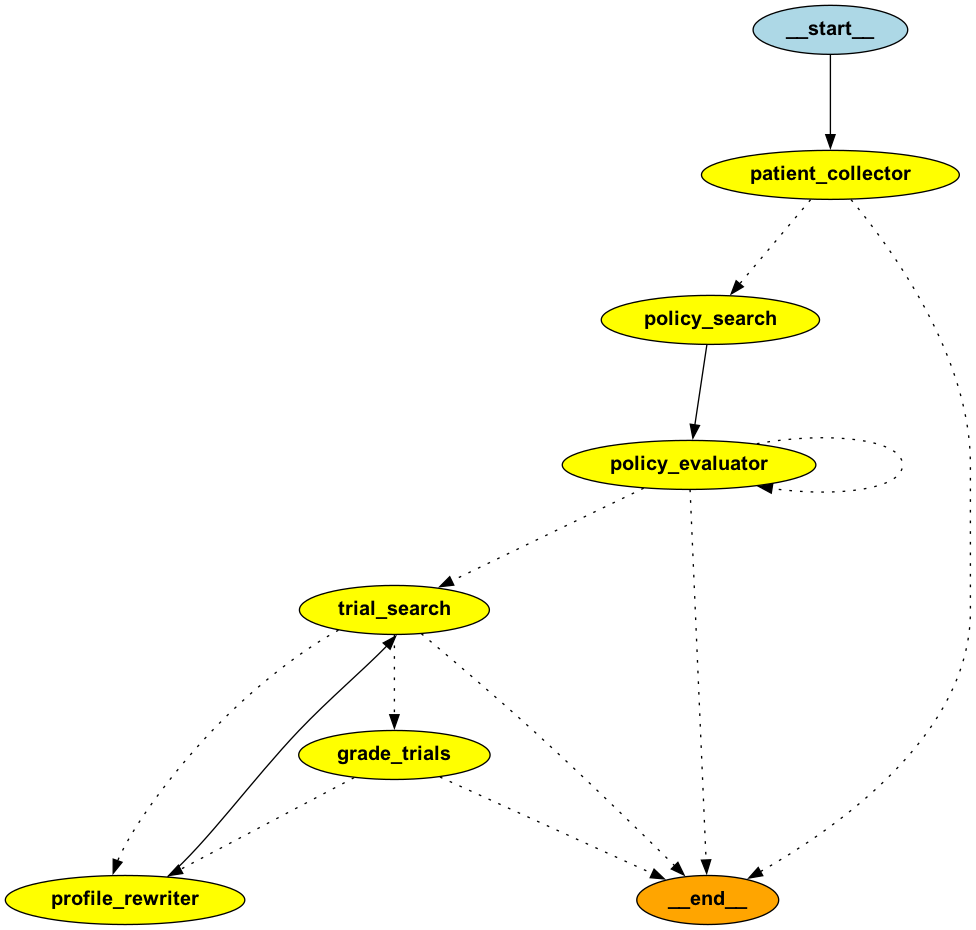

In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver
from helper_functions import create_workflow_builder, create_agent_state

conn = sqlite3.connect("checkpoints.sqlite", check_same_thread=False)
memory = SqliteSaver(conn)

# from langgraph.checkpoint.memory import InMemorySaver
# memory = InMemorySaver()

agent_state = create_agent_state()
builder = create_workflow_builder(agent_state)

graph = builder.compile(
    checkpointer=memory
)

from IPython.display import Image

Image(graph.get_graph().draw_png())

# Invoke the Graph with no GUI:
You can invoke the pipeline using the `stream` method. This is useful for debugging and the development phase.

The thread variable acts like different graph run profiles.

To use the LangGraph persistent and time travel capabilities, use the `resume_from_state` function from the `helper_functions` module.


In [ ]:
import langchain
langchain.debug = False
sample_patient_id = 2
thread = {"configurable": {"thread_id": "0"}}
events_gen = graph.stream({
    'patient_prompt': f"Is patient {sample_patient_id} eligible for any medical trial?",    
    "max_revisions": 10,
    "revision_number": 1,
    'max_trial_searches':3,
}, thread)

if DEBUG == True:
    for event in events_gen:
        print(event)

# Application GUI
For the sake of quick development, a GUI is designed based on the `gradio` python package and an adoption from [This tutorial course](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph). You can also use [streamlit](https://docs.streamlit.io/develop/tutorials/llms/build-conversational-apps) as another tool for GUI development.

In the applicaiton, the process is interupted at several intermediate points using the `interrupt_after` argument. At these points, the user (the clinical expert) can decide whether to alter the patient's profile by adding or removing relevant/non-relevant information. The user can also skip some of rejections at these intrupt points to continue with the process.


In [ ]:
from helper_gui import trials_gui
# from langgraph.checkpoint.memory import InMemorySaver
# memory = InMemorySaver()

conn = sqlite3.connect("checkpoints.sqlite", check_same_thread=False)
memory = SqliteSaver(conn)
# memory = SqliteSaver.from_conn_string(":memory:")

graph = builder.compile(
    checkpointer=memory,
    interrupt_after=['patient_collector', 'policy_search', 'trial_search', 'grade_trials', 'profile_rewriter']
    # , interrupt_after=['grade_trials','profile_rewriter']
)

try:
    app.demo.close()
except:
    print('initial run')
app = trials_gui(graph)    
app.demo.launch(server_name="127.0.0.1", server_port=7958)

Closing server running on port: 7958
* Running on local URL:  http://127.0.0.1:7958
* To create a public link, set `share=True` in `launch()`.


-------------- Check the next policy --------------
Evaluating Policy:
 #### 4. **Medication and Treatment Restrictions**
Patient ID: 56
{'patient_id': 56, 'name': 'John Doe', 'age': 58, 'medical_history': 'pancreatic cancer', 'previous_trials': 'NCT01457492', 'trial_status': 'Ongoing', 'trial_completion_date': None}
This is a 58-year-old patient with a history of pancreatic cancer.  They are currently participating in trial NCT01457492, which is ongoing.  Given their diagnosis, they may be eligible for clinical trials focused on pancreatic cancer treatments, such as immunotherapy or targeted therapies.  Additionally, trials investigating novel diagnostic tools or supportive care strategies for pancreatic cancer patients could be relevant. 





Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 23.42inputs/s]

Evaluating Policy:
 #### 4. **Medication and Treatment Restrictions**


Patient did not pass this policy.


#### 4. **Medication and Treatment Restrictions**
   - **Concurrent Medications**: Patients must not be on any medication that could interfere with the study drug, unless specified by the trial protocol.
   - **Substance Abuse**: Patients with a history of substance abuse within the past 12 months are excluded.
   - **Vaccinations**: Patients must not have received live vaccines within 30 days prior to the start of the trial.

Rejection Reason: 
'no'
You can correct the patient's medical profile if required.
Patient ID: 56
{'patient_id': 56, 'name': 'John Doe', 'age': 58, 'medical_history': 'pancreatic cancer', 'previous_trials': 'NCT01457492', 'trial_status': 'Ongoing', 'trial_completion_date': None}
This is a 58-year-old patient with a history of pancreatic cancer.  They are currently participating in trial NCT01457492, which is ongoing.  Given their diagnosis, they may be eligible for clinical trials focused on pancreatic cancer treatments, such a

Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 21.96inputs/s]


Evaluating Policy:
 #### 4. **Medication and Treatment Restrictions**
Patient did not pass this policy.


#### 4. **Medication and Treatment Restrictions**
   - **Concurrent Medications**: Patients must not be on any medication that could interfere with the study drug, unless specified by the trial protocol.
   - **Substance Abuse**: Patients with a history of substance abuse within the past 12 months are excluded.
   - **Vaccinations**: Patients must not have received live vaccines within 30 days prior to the start of the trial.

Rejection Reason: 
'no'
You can correct the patient's medical profile if required.
-------------- Check the next policy --------------
State updated
('policy_evaluator',)
Evaluating Policy:
 #### 4. **Medication and Treatment Restrictions**
Patient did not pass this policy.


#### 4. **Medication and Treatment Restrictions**
   - **Concurrent Medications**: Patients must not be on any medication that could interfere with the study drug, unless specified by th

# Possible Further Improvements for Real Application:

To enhance the robustness of the pipeline and effectively manage diverse patient and trial conditions, it is essential to implement advanced methodologies, particularly when handling large databases of patients, trials, and policies.

Recommended Improvements:
1. Graph-Based Retrieval-Augmented Generation (RAG):
- Implement graph-based RAG to focus on the relationships between entities across different databases. For instance, map connections between patients, diseases, drugs, and trials to provide more accurate and relevant information retrieval.

2. Advanced RAG pipeline:
- The output of RAG pipelines can be improved by benefiting from more advanced techniques such as Adaptive RAG, Corrective RAG, and Self-RAG. Such pipelines are more robust againts hallucinations and wrong inferences in LLMs outputs.

4. Advanced Chain of Thought Processing:
- Employ a more sophisticated chain of thought process to cross-match the patient's profile with the detailed information provided in each trial or policy. This approach enhances the decision-making capability of the system by considering multiple factors simultaneously.

1. Fine-Tuning the Large Language Model:
- Fine-tune the large language model using a diverse set of medical trial data to improve the accuracy and relevance of its inferences. This customization ensures the model better understands the nuances and specifics of clinical trial data.

1. Cyclic Graphs for Iterative Evaluation:
- Utilize cyclic graphs to iteratively evaluate the patient's profile against various trials and policies. This iterative approach allows the system to refine its matches through multiple rounds of evaluation, ultimately identifying the best possible trial for the patient.